# Experiment 1 - Split Connectivity [WIP]

## Details
Observe the effect of selective PN to iKC connectivity on the network's representational power.

Three topologies used:
- **Selective Connections**: Disjoint subsets of iKC neurons are connected to PNs corresponding to each input class's most active neurons. This way, connectivity between classes may overlap
- **Random Sparse**: Neurons are connected randomly with probabilty $p_{PN,iKC}$ (THIS IS STILL A WORK IN PROGRESS)

Neuron population sizes are as follows:

\begin{align}
& N_{PN} = \frac{d_{input}}{10}\\
& N_{iKC} = 20 \times N_{PN}\\
& N_{eKC} = N_{class}
\end{align}

where $d_{input}$ is the dimensionality of (flattened) image tensors, and $N_{class}$ is the number of classes.

Each input class contains 20 samples. Prior to spike coding, images are downscaled by a factor of 4. The top 10% most active pixels are calculated across samples within a class and their indices are used to select PN->iKC connectivity in the selective model. Images are encoded into spike times as instantaneous snapshots, with only the top 10% most active pixels per sample used as spikes. $N_{sample}$ images are randomly sampled from the set of inputs, keeping the number of samples from each class balanced. During training, samples are shown to the model within 50ms windows. 

> What would be the effect of adding either 1) Noise from random offsets of encoded spike times or 2) Noise from random spikes not correlated to the input patterns? Would the first facilitate easier learning of good representations? Would the second take away from this?

eKC neuron activity is measured as the spiking rate within a given interval: $\frac{N_{spike}(t)}{50}$, where $50$ is our interval duration, and $t$ indexes the current interval.

> What differences would come about when factoring in the per-interval spiking rate?

To analyse eKC population activity, we calculate:
- Population distance tables (Gaussian distance)


In [1]:
# Add my library
import sys
import os

sys.path.append(os.getcwd() + "/lib")

In [2]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pynn_genn as sim
from pyNN.random import NumpyRNG, RandomDistribution

import lib.simulation as S
import lib.metrics as metrics
from lib.model import default_populations, default_proj_iKC_eKC, default_params
from lib.data import Alphabet
from lib.embedding import spike_encode

In [3]:
def get_inputs(n_class, downscale=1):

    # Get n_class character sets from the "Alphabet of the Magi" alphabet
    data_dir = "omniglot/python/images_background"
    dataset = Alphabet(data_dir, 0)
    inputs = dataset[:n_class,:]

    # Downsample
    inputs = inputs[:,:,::downscale,::downscale]

    # Binarize
    inputs = inputs.round()

    # Invert
    inputs = 1 - inputs
    
    # Flatten
    __, c, w, h = inputs.shape
    inputs = inputs.reshape(-1, c, w * h)

    return inputs

Vector size: 441
New Dims: 21 21
(2, 20, 441)
Mean per-class sparsity ratio 
 -- 0: 0.9159
 -- 1: 0.9317


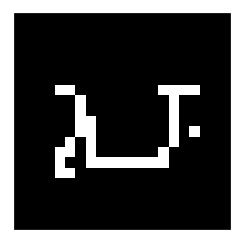

In [4]:
samples = get_inputs(2, downscale=5)
s = samples.shape[-1]
nw = int(np.sqrt(s))
nh = nw + (s - (nw * nw))

print("Vector size:", s)
print("New Dims:", nw, nh)

plt.imshow(samples[0,0].reshape((nw, nh)), cmap='gray')
plt.xticks([])
plt.yticks([])

print(samples.shape)
print("Mean per-class sparsity ratio ")
print(" -- 0: {:.4f}".format(np.mean([ 1 - s.mean() for s in samples[0] ])))
print(" -- 1: {:.4f}".format(np.mean([ 1 - s.mean() for s in samples[1] ])))

In [18]:
def setup_split_model(input_spikes, **params):
    n_class = params['n_class']
    
    # Population
    PN, iKC, eKC = default_populations(input_spikes, **params['population'])
   
    # Disjoint iKC subsets
    s_subset = int(params['population']['n_iKC'] / n_class)
    iKC_subsets = []
    for i in range(n_class):
        iKC_subsets.append(iKC[i*s_subset:i*s_subset+s_subset])
    
    # Projections
    stat_syn = params['syn_PN_iKC']
    aixs = params['active_indices']
    
    subset_projections = []
    for i, (ixs, subset) in enumerate(zip(aixs, iKC_subsets)):
        proj = sim.Projection(
            PN[ixs], subset,
            sim.FixedProbabilityConnector(0.9),
            sim.StaticSynapse(weight=stat_syn['g'], delay=stat_syn['tau']),
            receptor_type='excitatory',
            label=f"PN->iKC:{i}"
        )
        subset_projections.append(proj)
    
    proj_iKC_eKC = default_proj_iKC_eKC(iKC, eKC, **params['syn_iKC_eKC'])
    
    projections = { proj.label: proj for proj in subset_projections }
    projections["iKC_eKC"] = proj_iKC_eKC
    
    return {
        "model": sim.Assembly(PN, iKC, eKC),
        "projections": projections
    }

def setup(n_class, n_eKC, delta_t, t_snapshot, downscale):
   
    # Inputs
    inputs = get_inputs(n_class, downscale)
    spike_inputs, labels = spike_encode(inputs, t_snapshot=t_snapshot, start_time=t_snapshot)
    
    d_input = inputs.shape[-1]
    n_active = int(d_input * 0.1) # 10% active
    
    cvs = np.mean(inputs, axis=1)
    active_ixs = np.argsort(cvs)[:,-n_active:]
    
    d_input = inputs.shape[-1]
    n_sample = np.prod(inputs.shape[:2])
    
    # Neuron parameters
    neuron_iKC = sim.IF_cond_exp(**{
        "tau_m": 10,
    })
    
    neuron_eKC = sim.IF_cond_exp(**{
        "tau_m": 10
    })
    
    # Synapse parameters
    syn_PN_iKC = {
        'g': RandomDistribution('normal', (0.25, 0.1)),
    }
    
    syn_iKC_eKC = {
        'g': 0.01,
        'WD': sim.AdditiveWeightDependence(w_min=0.125, w_max=0.5)
    }
    
    # Model
    params = default_params(
        delta_t,
        t_snapshot,
        d_input,
        n_sample,
        n_eKC,
        neuron_iKC=neuron_iKC,
        neuron_eKC=neuron_eKC,
        syn_PN_iKC=syn_PN_iKC,
        syn_iKC_eKC=syn_iKC_eKC
    )
    
    params['n_class'] = 2
    params['active_indices'] = active_ixs
    
    MB = S.setup_experiment(spike_inputs, model_setup=setup_split_model, **params)
    
    return MB, params

In [19]:
sim.end()

# Setup the experiment
N_CLASS = 2
N_EKC = 50
DELTA_T = 0.1
T_SNAPSHOT = 50
DOWNSCALE = 4

mb, params = setup(
    N_CLASS, 
    N_EKC, 
    DELTA_T,
    T_SNAPSHOT,
    DOWNSCALE
)

AdditiveWeightDependence(<parameters>)


/home/bikeboi/Research/jra/code/lib/python3.8/site-packages/numpy/lib/histograms.py:822: RuntimeWarning: overflow encountered in double_scalars
  norm = n_equal_bins / _unsigned_subtract(last_edge, first_edge)
/home/bikeboi/Research/jra/code/lib/python3.8/site-packages/numpy/lib/histograms.py:850: RuntimeWarning: invalid value encountered in multiply
  f_indices = _unsigned_subtract(tmp_a, first_edge) * norm


IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 11

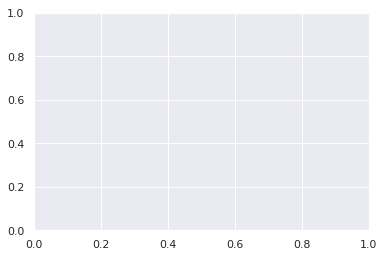

In [20]:
# Problem here
# The weights seem to different (a lot smaller) from what they should be. Need to fix

iKC_eKC = mb['projections']['iKC_eKC']
initial_weights = iKC_eKC.get('weight', format='array')

plt.hist(initial_weights)
plt.xlabel("weight")
plt.ylabel("density")
plt.title("Initial iKC->eKC weights")
plt.show()


In [10]:
# Run the experiment
intervals = np.arange(params['t_snapshot'], params['t_snapshot'] * params['n_sample'], params['t_snapshot'])
try:
    results = S.run_experiment(mb, intervals, **params)
finally:
    S.cleanup()

Running experiment

Ending Simulation...######################################################### ] 100% 


KeyboardInterrupt: 

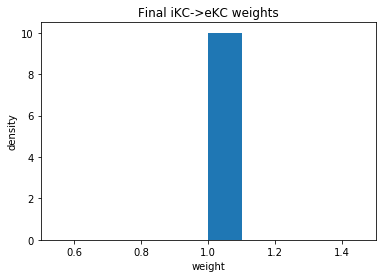

Mean: 1.0
Max: 1.0
Min: 1.0


In [36]:
final_weights = iKC_eKC.get('weight', format='array').flatten()
plt.hist(final_weights, density=True)
plt.xlabel("weight")
plt.ylabel("density")
plt.title("Final iKC->eKC weights")
plt.show()
print("Mean:", final_weights.mean())
print("Max:", final_weights.max())
print("Min:", final_weights.min())

Plotting panels...
Generating Figure...


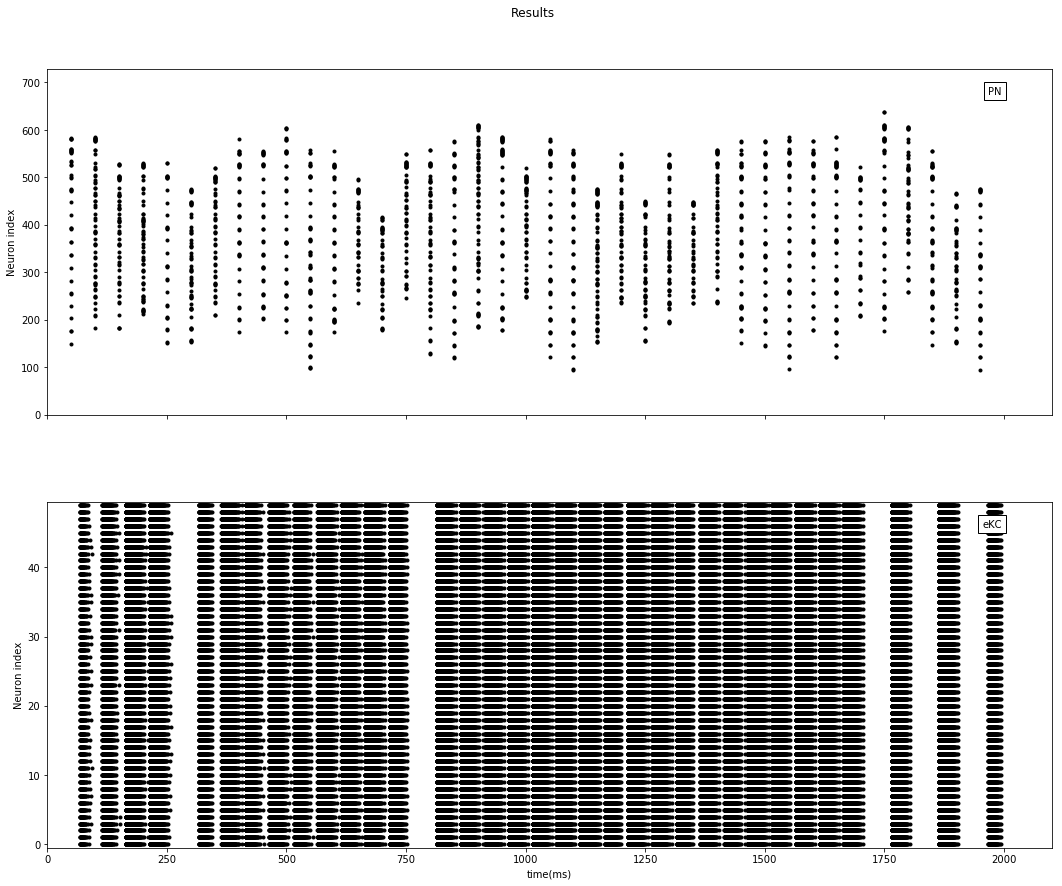

In [37]:
S.plot_results(results['data'], "Results", hide=['iKC'])
fig = plt.gcf()
fig.set_size_inches(18, 15)
plt.show()

In [19]:
# Activity analysis
def analysis(activity):
    rates = activity / 50 # Convert to rate
    return np.cov(rates)

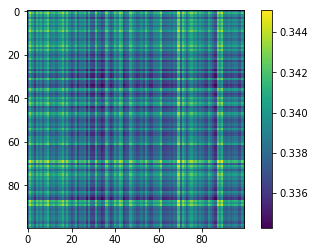

In [20]:
matrix = analysis(results['activity']['eKC'][0])
plt.imshow(matrix)
plt.colorbar()
plt.show()